In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics
import math

In [4]:
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [5]:
tempdf = pd.DataFrame()
tempdf['Tmean'] = dataframe[['pH','Salinity','Ammonia']].mean()
tempdf['Tstd'] = dataframe[['pH','Salinity','Ammonia']].std()
for date in dataframe['Date of Image'].unique():
  df = dataframe.loc[dataframe['Date of Image'] == date]
  tempdf[f'{date}_mean'] = df[['pH','Salinity','Ammonia']].mean()
  tempdf[f'{date}_std'] = df[['pH','Salinity','Ammonia']].std()

In [6]:
tempdf

,Tmean,Tstd,2022-07-14_mean,2022-07-14_std,2022-09-12_mean,2022-09-12_std,2023-04-25_mean,2023-04-25_std,2023-05-30_mean,2023-05-30_std,2023-07-09_mean,2023-07-09_std
pH,8.205357,0.361522,8.600,0.106904,8.43750,0.170783,7.6250,0.150000,7.900000,0.264575,8.166667,0.276887
Salinity,33.678571,6.390638,37.875,1.807722,35.56250,3.898183,26.0000,3.366502,24.923077,1.754116,39.066667,2.051712
Ammonia,0.043750,0.032784,0.000,0.000000,0.02625,0.015438,0.0275,0.009574,0.074615,0.025038,0.063333,0.024398


In [7]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,612,1253,1154,919,1025,1059,1171,920,1188,165
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,484,1179,1065,794,854,918,1042,737,993,131
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,432,1114,969,708,779,727,825,641,897,170
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,524,1127,950,798,734,844,963,614,952,157
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,710,1236,1162,1108,1114,1217,1268,828,1254,169


In [8]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 22


In [9]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [10]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.042532
Salinity    0.142014
Ammonia     0.065567
dtype: float64

## WQI calculation

In [11]:
# def derivative(dataframe):
#     banddata = dataframe[bands]
#     for wave,band in (wavelengths,bands):



#     return None

def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.2,0.2,0.6]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 15
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf

def bandmath(bandMatrix,WQI):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/bandMatrix[a] + bandMatrix[b]
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex
  df['WQI_cal'] = WQI
  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  return  pca_data

def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 2.,  3.,  5.,  1., 10.,  7., 15., 10.,  2.,  1.]),
 array([ 9.06666667, 13.26666667, 17.46666667, 21.66666667, 25.86666667,
        30.06666667, 34.26666667, 38.46666667, 42.66666667, 46.86666667,
        51.06666667]),
 <BarContainer object of 10 artists>)

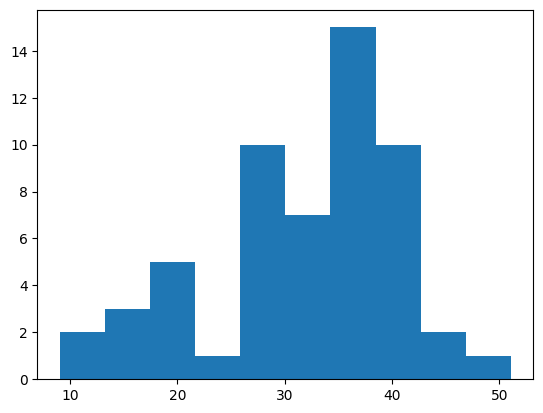

In [12]:
wqi,expdf= calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [13]:

## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 31.80952380952381
Standard Deviation WQI 9.106573747885943


## Model for the WQI to indiviual parameter

In [14]:


def CM(actual, predicted,x,y):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  # vs  = pd.DataFrame(validationdataframe)
  # print(vs)
  plt.scatter(x,y)
  plt.show()

def Presults(y_test, prediction):
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_

def LRegression(dataframe,index,name,WQI_val,GT_val,):
  # CM(dataframe[name],dataframe[index])
  # for i ,j in zip(dataframe[index],WQI_val):
  #   print(i,j)
  # dataframe[index] = scaler.inverse_transform(np.array(dataframe[index]).reshape(-1, 1))
  # WQI_val = scaler.inverse_transform(np.array(WQI_val).reshape(-1, 1))
  # for i ,j in zip(dataframe[index],WQI_val):
  #   print(i,j)

  validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
  traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

  CM(dataframe[name],dataframe[index],validationdataframe[name],validationdataframe[index])

  xTrain = np.array((traindataframe[index])).reshape(-1, 1)
  yTrain = traindataframe[name]
  xTest = np.array((validationdataframe[index])).reshape(-1, 1)
  yTest = validationdataframe[name]

  # xTrain, xTest, yTrain, yTest = train_test_split(dataframe[index], dataframe[name], test_size=0.33, random_state=42)
  # xTrain = np.array(xTrain).reshape(-1, 1)
  # yTrain = np.array(yTrain).reshape(-1, 1)
  # xTest = np.array(xTest).reshape(-1, 1)
  # yTest = np.array(yTest).reshape(-1, 1)

  model = LinearRegression().fit(xTrain, yTrain)
  # model = SVR(kernel='rbf', C=1.0, epsilon=1e-4).fit(xTrain, yTrain)
  if name == 'Ammonia':
  #   # print('hi')
      model = RandomForestRegressor(max_depth=2, random_state=0).fit(xTrain, yTrain)
  prediction = model.predict(xTest)
  prediction_val = model.predict(WQI_val)
  # for x,y in zip(yTest.values,prediction):
  #   print(x,'-',y)
  plt.figure(figsize=(5,5))
  # plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red",label = 'Actual')
  # plt.scatter(np.arange(1, len(yTest)+1), prediction, color="blue",label = 'Predicted')
  plt.scatter(yTest,prediction)
  lims = [max(max(yTest),max(prediction)),min(min(yTest),min(prediction))]

  plt.xlim([0.95*lims[1],1.05*lims[0]])
  plt.ylim([0.95*lims[1],1.05*lims[0]])
  # plt.legend()
  plt.show()

  Presults(yTest, prediction)
  print(f"validation results on {name}")
  Presults(GT_val,prediction_val)
  for x,y in zip(GT_val,prediction_val):
    print(x,'-',y)
  print(f"---------------------------------------")


#to predict the parameters from WQI



def WQIandParameters(dataframe,index,predictedWQI,gtforRE):
  print('-----For WQI with pH Regression relation-----')
  LRegression(dataframe,index,'pH',predictedWQI,gtforRE['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(dataframe,index,'Salinity',predictedWQI,gtforRE['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(dataframe,index,'Ammonia',predictedWQI,gtforRE['Ammonia'])
  return None



In [15]:
### adding wqi as a dataframe

dataframe["WQI"] = wqi
print(dataframe['WQI'].head())
scaler2 = MinMaxScaler()
# scaler2 = StandardScaler()
dataframe['WQI'] = scaler2.fit_transform(dataframe[['WQI']]).flatten()
print(dataframe['WQI'].head())

0    31.333333
1    39.333333
2    40.000000
3    40.666667
4    36.000000
Name: WQI, dtype: float64
0    0.530159
1    0.720635
2    0.736508
3    0.752381
4    0.641270
Name: WQI, dtype: float64


In [16]:
# sns.pairplot(dataframe)

## Model for Band to WQI index

In [17]:

def scaling(Banddata):
    scaler = StandardScaler()
    scaler.fit(Banddata)
    dataframe = scaler.transform(Banddata)
    return dataframe

def pca(dataframe):
  pca = PCA(n_components=3)
  pca.fit(dataframe)
  pca_df =  pca.transform(dataframe)
  return pca_df

# def weakmodel(xTrain, yTrain,xTest):
#       models = [
#         RandomForestRegressor(max_depth=3, random_state=0),
#         xgb.XGBRegressor(),
#         SVR(kernel='rbf', C=1.0, epsilon=1e-3)]

#       preds = []
#       for i, m in enumerate(models):
#           m.fit(xTrain, yTrain)
#           preds.append(m.predict(xTest))

#       weights = [0.33, 0.33,0.33]
#       preds = np.array(preds)
#       print
#       preds= np.sum(preds, axis = 0)/3
#       return preds

### model to predict WQI using bands as input
def predictWQI(dataframe,pred):
    # validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    traindataframe.to_csv('WQIModelTrain.csv')
    validationdataframe.to_csv('WQIModelTest.csv')

    validationdataframe2 = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    traindataframe2 = scaling(dataframe[dataframe["Date of Image"]=="2023-07-09"][bands])
    # k =  10
    # k_fold = KFold(n_splits = k,shuffle=True )


    gtforRE = (validationdataframe[parameters])
    gtforRE2 = (validationdataframe2[parameters])

    xTrain = (scaling(traindataframe[bands]))
    yTrain = traindataframe[pred]
    xTest = (scaling(validationdataframe[bands]))
    yTest = validationdataframe[pred]

    model = SVR(kernel='rbf', C=2.0, epsilon=1e-4)
    # model = RandomForestRegressor(max_depth=3, random_state=0)
    # model = MLPRegressor(random_state=1, max_iter=100000)

    model.fit(xTrain, yTrain)

    # score = cross_val_score(model, dataframe[bands], dataframe[pred], cv = k_fold)
    # print(sum(score) / len(score))
    # print(score)
    # prediction =  weakmodel(xTrain,yTrain,xTest)
    prediction = model.predict(xTest)
    # prediction = preds
    # print(prediction,yTest)
    predition2  = model.predict(traindataframe2)

    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction,predition2,gtforRE,gtforRE2

In [18]:
(dataframe).corrwith(dataframe['WQI'],method = 'spearman')

<ipython-input-18-aa275eb3de0b>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['WQI'],method = 'spearman')
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


pH             0.793702
Salinity       0.794397
Carbonate      0.755858
BiCarbonate   -0.379684
Alkalinity     0.140849
Hardness       0.144744
Calcium       -0.544859
Magnesium      0.797864
Ammonia       -0.187015
Coincidence         NaN
B1            -0.628100
B10           -0.343554
B11           -0.513090
B12           -0.492686
B2            -0.683347
B3            -0.667948
B4            -0.679427
B5            -0.645396
B6            -0.619482
B7            -0.611969
B8            -0.624205
B8A           -0.599426
B9            -0.486113
WQI            1.000000
dtype: float64

(array([ 2.,  3.,  5.,  1., 10.,  7., 15., 10.,  2.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

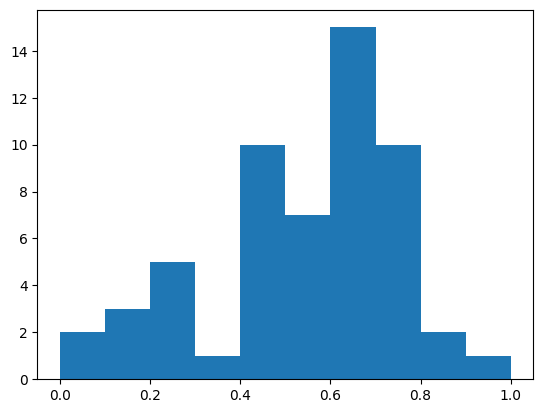

In [19]:

plt.hist(dataframe['WQI'])

MAE 0.11659160413781369
MSE 0.022019849516414475
RMSE 0.1483908673618915
MAPE 0.4603965639159559
R2 Score 0.5253074282678705


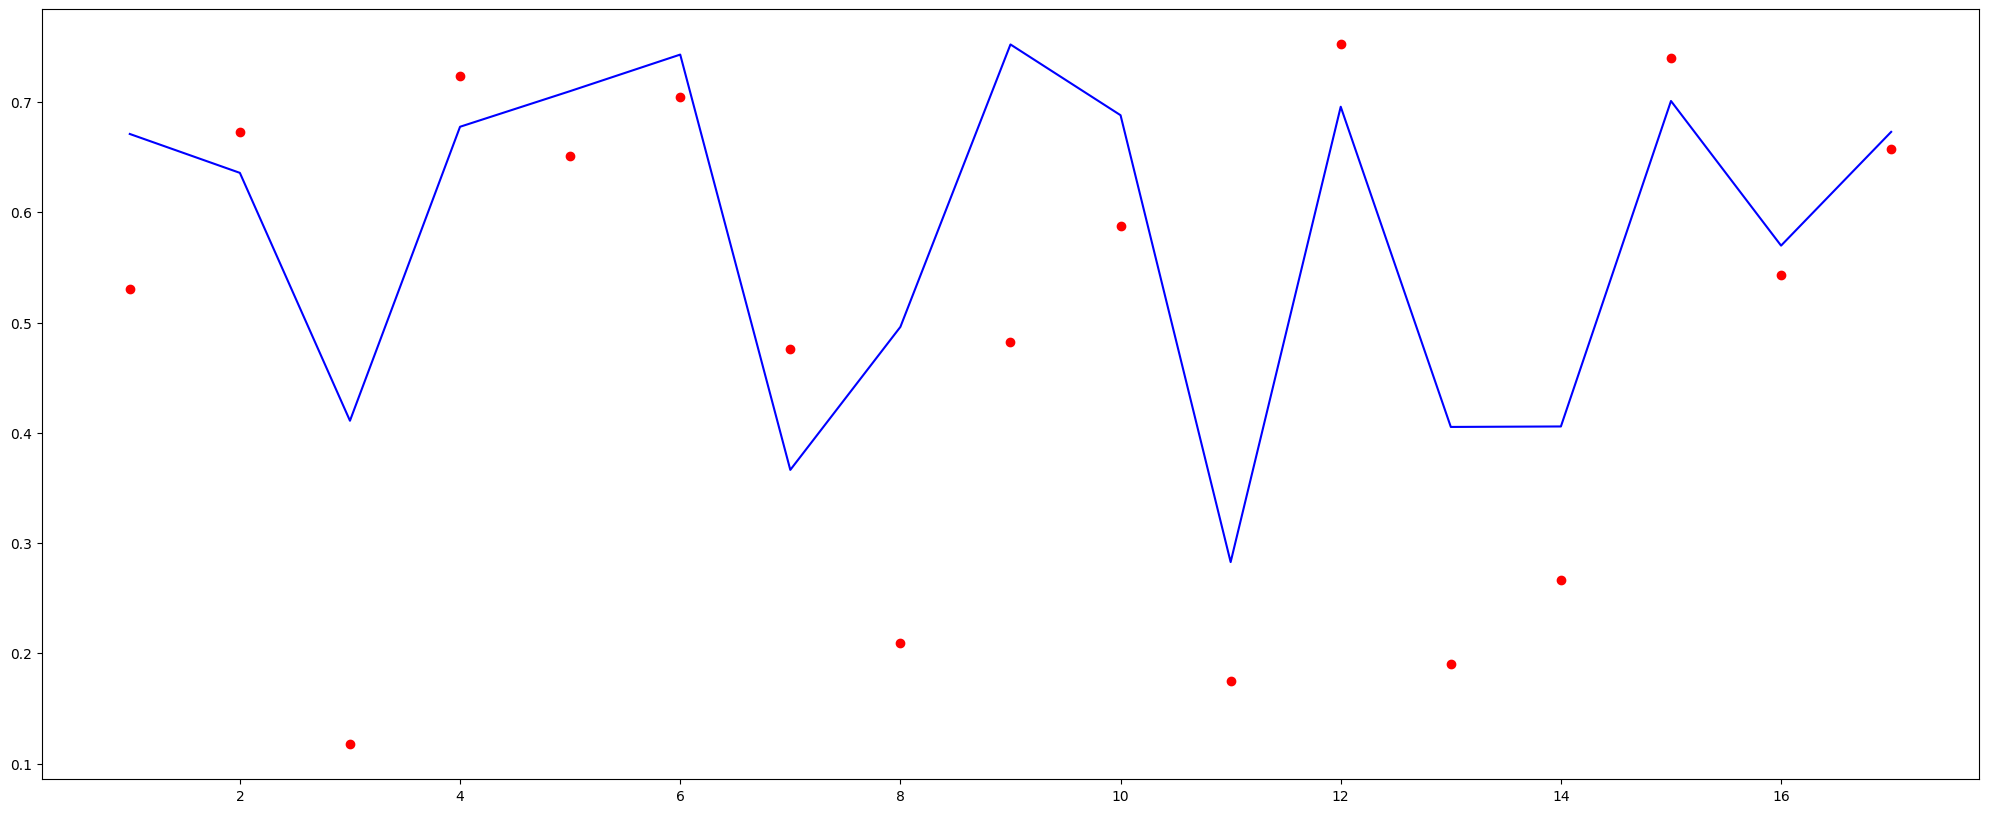

In [20]:

predictedWQI,precitedWQIFixD,gtforRE ,gtforRE2= predictWQI(dataframe,"WQI")

0    0.530159
1    0.720635
2    0.736508
3    0.752381
4    0.641270
Name: WQI, dtype: float64
-----For WQI with pH Regression relation-----


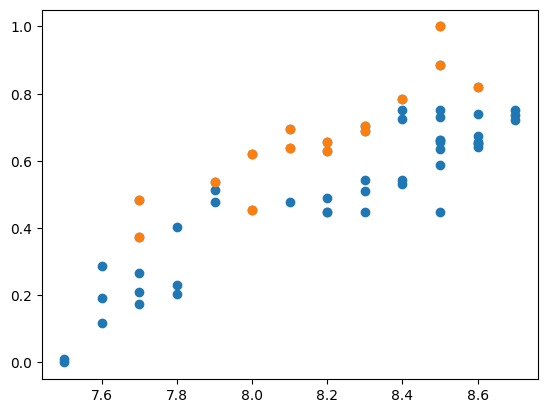

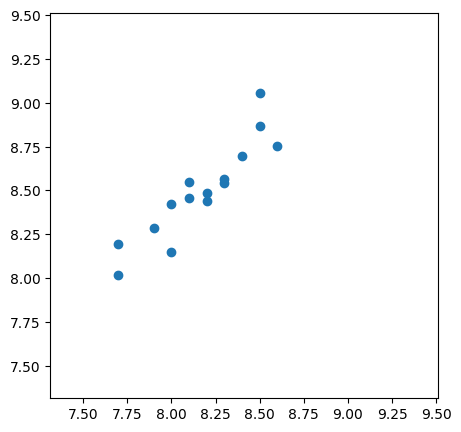

MAE 0.33257459178789667
MSE 0.12355290367542883
RMSE 0.3515009298357955
MAPE 0.040871650733126354
R2 Score -0.7266710140976087
validation results on pH
MAE 0.24420293148642963
MSE 0.11626826917490607
RMSE 0.340981332590079
MAPE 0.03102439517166314
R2 Score 0.32090683525570196
8.4 - 8.510025145651802
8.6 - 8.451310695940233
7.6 - 8.077128247361886
8.4 - 8.5209019035899
8.6 - 8.574704691592702
8.3 - 8.629856878335627
7.9 - 8.002924186570539
7.7 - 8.218763522350645
7.7 - 8.645161416401024
8.5 - 8.538325516157355
7.7 - 7.863748132908384
8.7 - 8.551132893809404
7.6 - 8.067757441736584
7.7 - 8.068476124261656
8.6 - 8.55980980159119
8.4 - 8.341489928256468
8.6 - 8.513170668866097
---------------------------------------
-----For WQI with Salinity  Regression relation-----


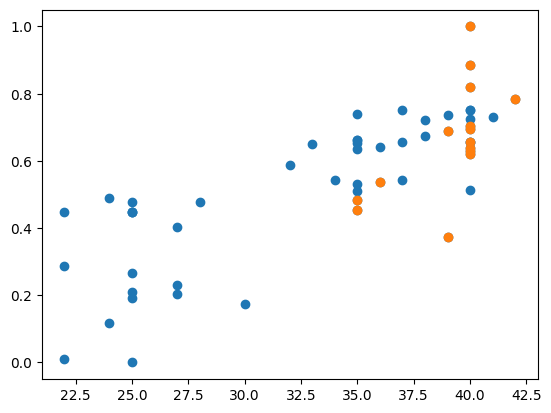

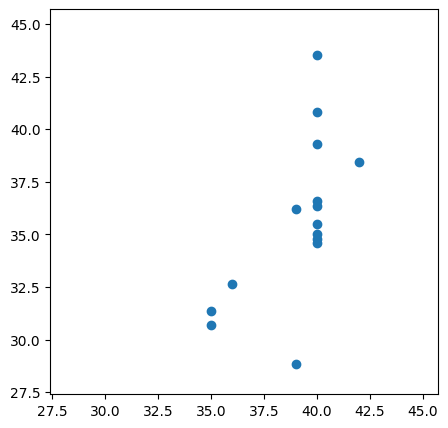

MAE 3.9969362574933256
MSE 20.394588316084516
RMSE 4.516036793039281
MAPE 0.10269926420280802
R2 Score -4.1909302840712845
validation results on Salinity
MAE 3.3150265271445525
MSE 13.627600214676471
RMSE 3.691557965774948
MAPE 0.1115657704748594
R2 Score 0.5743216102419477
35 - 35.80440987597622
38 - 34.97636228327779
24 - 29.69928181505629
40 - 35.957804368664966
33 - 36.71658298798333
40 - 37.49439212506757
25 - 28.652784841848447
25 - 31.696758570297177
35 - 37.710231428078465
32 - 36.20352889667238
30 - 26.68999038899498
40 - 36.384150843836245
25 - 29.567125709058626
25 - 29.577261260660045
35 - 36.506520935629126
34 - 33.42756428286131
37 - 35.848771067099854
---------------------------------------
-----For WQI with Ammonia SVR relation-----


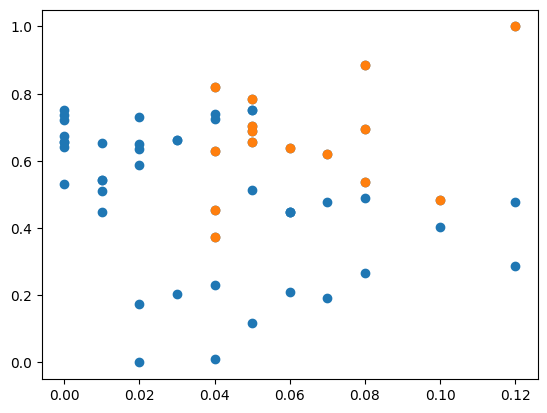

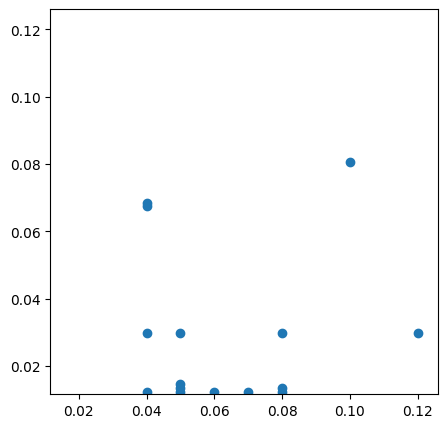

MAE 0.0415133342046217
MSE 0.002164366908381502
RMSE 0.04652275688715687
MAPE 0.6538627934654039
R2 Score -2.8958604350867043
validation results on Ammonia
MAE 0.020322849298928695
MSE 0.0007573179402386404
RMSE 0.02751941024510955
MAPE 13894258511113.842
R2 Score 0.40396273221958845
0.0 - 0.013370921199151273
0.0 - 0.012334703813595652
0.05 - 0.06843693933646333
0.04 - 0.013370921199151273
0.02 - 0.014643876292303737
0.05 - 0.02819971637817993
0.12 - 0.06868277266979667
0.06 - 0.06447544430661695
0.1 - 0.029909602216978814
0.02 - 0.013370921199151273
0.02 - 0.06730121284073683
0.0 - 0.013370921199151273
0.07 - 0.06843693933646333
0.08 - 0.06843693933646333
0.04 - 0.014643876292303737
0.01 - 0.012522939107713299
0.0 - 0.013370921199151273
---------------------------------------


In [21]:

# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)

print(dataframe["WQI"].head())

# dataframe['WQI'] = scaler2.inverse_transform(dataframe[['WQI']]).flatten()
# print(dataframe["WQI"].head())
WQIandParameters(dataframe,'WQI',predictedWQI.reshape(-1, 1),gtforRE)
# WQIandParameters(dataframe,'WQI',precitedWQIFixD.reshape(-1, 1),gtforRE2)

Mean WQI 0.581407204186913
Standard Deviation WQI 0.15267983415665665


(array([1., 1., 3., 0., 1., 0., 1., 1., 6., 3.]),
 array([0.28271855, 0.32966924, 0.37661992, 0.42357061, 0.47052129,
        0.51747198, 0.56442266, 0.61137334, 0.65832403, 0.70527471,
        0.7522254 ]),
 <BarContainer object of 10 artists>)

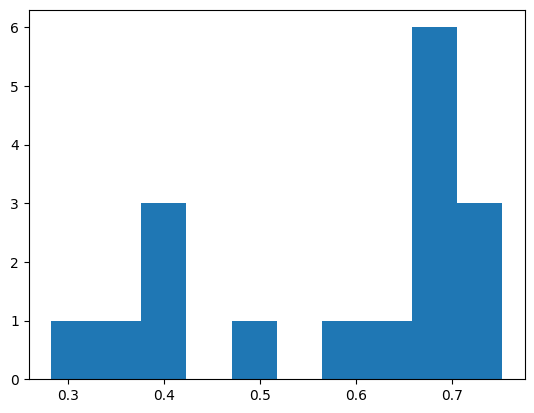

In [22]:
#
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(predictedWQI))
print("Standard Deviation WQI", statistics.stdev(predictedWQI))
plt.hist(predictedWQI)

In [23]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold
from numpy import absolute,mean,std
from sklearn.linear_model import Ridge,HuberRegressor

In [24]:
# model = LinearSVR()
# model = Ridge(alpha = .002,random_state=123)
model = HuberRegressor(max_iter = 1000)
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

In [59]:
X = np.array(dataframe['WQI']).reshape(-1, 1)
y = dataframe[parameters]


In [60]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 1.090 (0.316)


In [61]:
validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]
xTrain = np.array(traindataframe['WQI']).reshape(-1, 1)
yTrain = traindataframe[parameters]
xTest =  np.array(validationdataframe['WQI']).reshape(-1, 1)
yTest = validationdataframe[parameters]

# xTrain, xTest, yTrain, yTest = train_test_split(np.array(dataframe['WQI']).reshape(-1, 1), dataframe[parameters], test_size=0.33, random_state=42)

In [62]:
regr = wrapper.fit(xTrain, yTrain)
prediction = regr.predict(xTest)
Presults(yTest, prediction)

MAE 1.3775371946269859
MSE 6.061724740675172
RMSE 1.5582140747059794
MAPE 0.23232563241125959
R2 Score -2.5892676815908047


In [63]:
for index, col in enumerate(yTest.columns):
  yTest[f'{col}_pred'] = prediction[:,index]

<ipython-input-63-ed4dba7d913f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yTest[f'{col}_pred'] = prediction[:,index]
<ipython-input-63-ed4dba7d913f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yTest[f'{col}_pred'] = prediction[:,index]
<ipython-input-63-ed4dba7d913f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [64]:
yTest

,pH,Salinity,Ammonia,pH_pred,Salinity_pred,Ammonia_pred
51,8.0,35,0.04,8.174077,31.080879,0.035002
52,8.5,40,0.08,8.900330,41.176923,0.012500
53,8.1,40,0.08,8.579924,36.722786,0.022428
54,8.2,40,0.05,8.515843,35.831959,0.024413
55,7.9,36,0.08,8.312920,33.011005,0.030701
56,7.7,35,0.10,8.222138,31.749000,0.033513
57,8.5,40,0.12,9.092573,43.849405,0.006544
58,8.2,40,0.04,8.467782,35.163838,0.025902
59,8.4,42,0.05,8.729447,38.801383,0.017795
60,8.0,40,0.07,8.451762,34.941131,0.026399


In [65]:
Presults(yTest['pH'], yTest['pH_pred']),Presults(yTest['Salinity'], yTest['Salinity_pred']),Presults(yTest['Ammonia'], yTest['Ammonia_pred'])

MAE 0.3616366429794946
MSE 0.14386943418572695
RMSE 0.37930124464036097
MAPE 0.044423656445540714
R2 Score -1.0105976827197876
MAE 3.7316687297131788
MSE 18.03899043597204
RMSE 4.247233268372723
MAPE 0.09581994635748249
R2 Score -3.5913720001060048
MAE 0.03930621118828453
MSE 0.0023143518677481226
RMSE 0.04810771110485431
MAPE 0.5567332944307556
R2 Score -3.1658333619466212


(None, None, None)

In [66]:
unkval = predictedWQI.reshape(-1, 1)
kval = gtforRE.copy()
prediction = regr.predict(unkval)
Presults(gtforRE, prediction)

MAE 1.22031688647979
MSE 4.9193484796613705
RMSE 1.4055492129127423
MAPE 8407650333019.497
R2 Score 0.26986664450343356


In [67]:
for index, col in enumerate(kval.columns):
  kval[f'{col}_pred'] = prediction[:,index]

In [68]:
kval

,pH,Salinity,Ammonia,pH_pred,Salinity_pred,Ammonia_pred
0,8.4,35,0.00,8.539203,36.156691,0.023689
5,8.6,38,0.00,8.479860,35.331739,0.025528
45,7.6,24,0.05,8.101676,30.074382,0.037246
13,8.4,40,0.04,8.550196,36.309513,0.023349
19,8.6,33,0.02,8.604574,37.065455,0.021664
62,8.3,40,0.05,8.660316,37.840357,0.019937
48,7.9,25,0.12,8.026678,29.031797,0.039569
37,7.7,25,0.06,8.244826,32.064393,0.032810
56,7.7,35,0.10,8.675784,38.055390,0.019458
12,8.5,32,0.02,8.567806,36.554319,0.022803


In [69]:
Presults(kval['pH'], kval['pH_pred']),Presults(kval['Salinity'], kval['Salinity_pred']),Presults(kval['Ammonia'], kval['Ammonia_pred'])

MAE 0.2518135021618591
MSE 0.1269065839121764
RMSE 0.35623950358175666
MAPE 0.03206780118333357
R2 Score 0.258771165104709
MAE 3.3807243539522496
MSE 14.629878196234305
RMSE 3.824902377346944
MAPE 0.11500271529044599
R2 Score 0.5430139646874499
MAE 0.028412803325261506
MSE 0.0012606588376287138
RMSE 0.03550575780952596
MAPE 25222950999058.344
R2 Score 0.007814803718141805


(None, None, None)

In [261]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import fsolve

In [262]:
validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]
X_new = np.array(traindataframe['WQI']).reshape(-1, 1)
y_new = np.asarray(traindataframe[parameters])

X_new_val = np.array(validationdataframe['WQI']).reshape(-1, 1)
y_new_val = np.asarray(validationdataframe[parameters])


In [263]:
# y_new = np.array(dataframe['WQI'],dtype=np.float64).reshape(-1, 1).ravel()
# X_new = np.asarray(dataframe['pH']).reshape(-1, 1)

In [264]:
X_new.shape

(41, 1)

In [265]:
y_new.shape

(41, 3)

In [267]:
pf = PolynomialFeatures(degree = 4).fit(X_new)
X_poly = pf.transform(X_new).astype(float)
X_poly[0]
regression_model = LinearRegression()

regression_model.fit(X_poly, y_new)

y_pred = regression_model.predict(X_poly)
print(regression_model.coef_)

mean_squared_error(y_new, y_pred, squared=False)

[[ 0.00000000e+00  1.64727761e+00 -7.63848616e+00  2.42965573e+01
  -1.93860880e+01]
 [ 0.00000000e+00  7.14604480e+01 -4.91671891e+02  1.11252863e+03
  -7.31415085e+02]
 [ 0.00000000e+00 -3.21548758e-01  4.00459153e+00 -1.02301408e+01
   7.29443181e+00]]


1.0495502532337635

In [268]:
Y_val_pred = regression_model.predict(pf.transform(X_new_val).astype(float))

MAE 0.09550243868813064
MSE 0.016949309533724654
RMSE 0.13018951391615477
MAPE 0.011638626185186905
R2 Score 0.8857861407592754
MAE 0.46253456458482256
MSE 0.4216433374334248
RMSE 0.6493406944227543
MAPE 0.05620626677330878
R2 Score -4.892531113200039


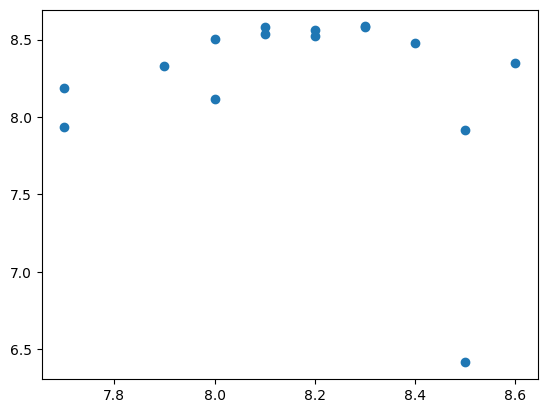

In [270]:
Presults(y_new[:,0],y_pred[:,0])
Presults(y_new_val[:,0],Y_val_pred[:,0])
plt.figure()
plt.scatter(y_new_val[:,0],Y_val_pred[:,0])
plt.show()

In [243]:
# from scipy.optimize import fsolve
# sub_X_poly = X_poly[:3]
# sub_y_new = y_new[:3]
# def f(w):
#     f = np.zeros(len(sub_X_poly))
#     for i in range(len(f)):
#         f[i] = X_poly[i,0] +X_poly[i,1]*w[0] +X_poly[i,2] *w[1]+\
#              X_poly[i,3]*w[2] + X_poly[i,4] *(w[0]**2) +X_poly[i,5]*(w[1]**2) +\
#              X_poly[i,6]*(w[2]**2) +X_poly[i,7]*(w[0]*w[1]) +X_poly[i,8]*(w[1]*w[2])+\
#              X_poly[i,9]*(w[0]*w[2]) - sub_y_new[i]
#       # f[i] = X_poly[i,0] +X_poly[i,1]*w[0] +X_poly[i,2] *w[1]+\
#       #        X_poly[i,3]*w[2] + X_poly[i,4] *(w[0]**2) +X_poly[i,5]*(w[1]**2) +\
#       #        X_poly[i,6]*(w[2]**2) +X_poly[i,7]*(w[0]*w[1]) +X_poly[i,8]*(w[1]*w[2])+\
#       #        X_poly[i,9]*(w[0]*w[2]) - sub_y_new[i]
#     return f
# # z = fsolve(f,[1,1]); print(z)
# # z = fsolve(f,[-2,-2]); print(z)
# # generate an initial guess
# initialGuess=[0,0,0]

# # solve the problem
# solutionInfo=fsolve(f,initialGuess,full_output=1)


# HQWI Index


In [38]:
allWQI = harmonizedWQIcalculation(dataframe[parameters])
dataframe['HWQI'] = allWQI
scaler3 = MinMaxScaler()
dataframe['HWQI'] = scaler3.fit_transform(dataframe[['HWQI']]).flatten()

(array([ 4.,  3.,  1., 20.,  5., 15.,  3.,  3.,  0.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

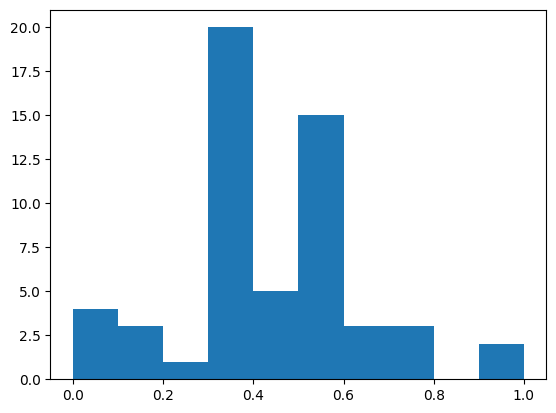

In [39]:
plt.hist(dataframe['HWQI'])

In [40]:
(dataframe).corrwith(dataframe['HWQI'])

<ipython-input-40-0036a586283d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['HWQI'])


pH             0.106968
Salinity       0.559821
Carbonate     -0.014115
BiCarbonate   -0.051408
Alkalinity    -0.010036
Hardness       0.433366
Calcium       -0.268119
Magnesium      0.457176
Ammonia        0.585113
Coincidence         NaN
B1            -0.494090
B10           -0.388352
B11           -0.323860
B12           -0.368513
B2            -0.551185
B3            -0.596716
B4            -0.556939
B5            -0.448563
B6            -0.405611
B7            -0.383047
B8            -0.440615
B8A           -0.398462
B9            -0.454930
WQI            0.599607
HWQI           1.000000
dtype: float64

In [42]:
# predictedWQI,gtforRE = predictWQI(dataframe,"HWQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)
# WQIandParameters(dataframe,'HWQI',predictedWQI.reshape(-1, 1),gtforRE)
# WQIandParameters(dataframe,'HWQI',predictedWQI.reshape(-1, 1),gtforRE,scaler3)
# WQIandParameters(np.array(dataframe['HWQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

In [ ]:
## Not good code

In [ ]:


# #to train model to predict the WQI using band  indcies using ML
# def WQIandBands(df1,WQI):
#   print('-----For WQI prediction with Bands with SVR algo -----')
#   X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
#   X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
#   # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
#   model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
#   model.fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   return prediction


# def CM(actual, predicted):
#   fig = plt.figure()
#   plt.scatter(actual, predicted)
#   plt.show()

# def LRegression(WQI,GT):
#   X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
#   model = LinearRegression().fit(X_train, y_train)
#   # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
#   # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   for x,y in zip(y_test.values,prediction):
#     print(x,'-',y)

#   CM(WQI,GT)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   # return model.coef_,model.intercept_
# #to predict the parameters from WQI



# def WQIandParameters(WQI,GT):
#   print('-----For WQI with pH Regression relation-----')
#   LRegression(WQI,GT['pH'])
#   print('-----For WQI with Salinity  Regression relation-----')
#   LRegression(WQI,GT['Salinity'])
#   print('-----For WQI with Ammonia SVR relation-----')
#   LRegression(WQI,GT['Ammonia'])
#   return None



## WQI with only bands

In [ ]:
# WQI = WQIcalculation(df1 ,GT1)
# # len(WQI)
# WQIandBands(df1,WQI)
# WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

## WQI with  top  10 combination indices

In [ ]:
#   corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
# type(corrwithWQI)
# corrdict  = corrwithWQI.to_dict()
# sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
# for r in sortedkeys[:11]:
#     print(r, corrdict[r])

In [ ]:
# newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
# scaler = StandardScaler()
# scaler.fit(newtraindf)
# newscaledtraindf = scaler.transform(newtraindf)
# WQIandBands(newscaledtraindf,WQI)

In [ ]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands